In [1]:
import gym

gym.envs.registry.all()

dict_values([EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v1), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v1), EnvSpec(FrozenLake-v1), EnvSpec(FrozenLake8x8-v1), EnvSpec(CliffWalking-v0), EnvSpec(Taxi-v3), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSpec(Swimmer-v3), EnvSpec(Walker2d-v2), EnvSpec(Walker2d-v3), EnvSpec(Ant-v2), EnvSpec(Ant-v3), EnvSpec(Humanoid-v2), EnvSpec(Humanoid-v3), EnvSpec(HumanoidStandup-v2), EnvSpec(FetchSlide-v1), EnvSpec(FetchPickAndPlace-v1), EnvSpec(FetchReach-v1), EnvSpec(FetchPush-v1), EnvSpec(HandReach-v0), EnvSpec(HandManipula

In [2]:
env = gym.make('CartPole-v1')
env.seed(42)
obs = env.reset()
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545], dtype=float32)

In [3]:
env.render()

True

In [4]:
img = env.render(mode='rgb_array')
img.shape

(400, 600, 3)

In [5]:
def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render(mode='rgb_array')
    plt.imshow(img)
    plt.axis('off')
    return img

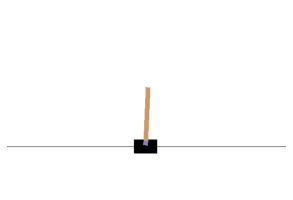

In [6]:
import matplotlib.pyplot as plt

plot_environment(env)
plt.show()

In [7]:
env.action_space

Discrete(2)

In [8]:
action = 1
obs, reward, done, info = env.step(action)
obs

array([-0.01261699,  0.1929279 ,  0.04204097, -0.28092128], dtype=float32)

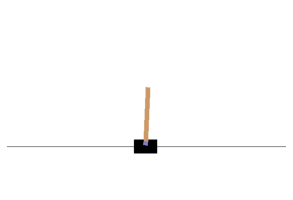

In [9]:
plot_environment(env)
plt.show()

In [10]:
reward

1.0

In [11]:
done

False

In [12]:
info

{}

In [13]:
if done:
    obs = env.reset()

In [14]:
env.seed(42)

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [15]:
import numpy as np

np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.718, 8.858356280936096, 24.0, 68.0)

A simple hard-coded policy

In [16]:
env.seed(42)

frames = []
obs = env.reset()
for step in range(200):
    img = env.render(mode='rgb_array')
    frames.append(img)
    action = basic_policy(obs)
    obs, reward, done, info = env.step(action)
    if done:
        break

In [17]:
import matplotlib as mpl
import matplotlib.animation as animation

mpl.rc('animation', html='jshtml')

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch), 
        frames=len(frames), repeat=repeat, interval=interval,
    )
    plt.close()
    return anim

In [18]:
plot_animation(frames)

In [19]:
env.close()

Neural Network Policies

In [20]:
n_inputs = 4 # == env.observation_space.shape[0]

In [21]:
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation='elu', input_shape=[n_inputs]),
    keras.layers.Dense(1, activation='sigmoid'),
])

In [22]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make('CartPole-v1')
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode='rgb_array'))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [23]:
frames = render_policy_net(model)
plot_animation(frames)

In [24]:
n_environments = 50
n_iterations = 5000

envs = [gym.make('CartPole-v1') for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print(f'\rIteration: {iteration + 1}/{n_iterations}, Loss: {loss.numpy():.3f}', end='')
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

Iteration: 5000/5000, Loss: 0.094

In [25]:
frames = render_policy_net(model)
plot_animation(frames)